# Why we care

A lot of data is inherently location-based and this trend is increasing.  
- Any data that is county, state, country, city, etc. is tied to a geographic location on the ground
- Addresses
- Photos
- Businesses
- Satelite imagery

In order to unlock the full power of this data or to visualize it, we need to really treat it as geographic data.  

Sometimes it's important to do things like:
- Test if an address is within a county
- Aggregate data
- Figure out distances between points


**This lecture will cover:**
- using maps to display data
- other operations on geographic data

# A few mapping basics


**Projections:**  
There are a lot of different projections that are used.  A projection refers to the process used to convert points on the earth (more or less a sphere) to a flat surface like a map or computer monitor.

(This is largely beyond our scope here, but it is can be very important to pay attention to if one is going to do a lot with GIS data.)


**Latitude** is degrees north or south of the equator.  (-90 to 90) Lines of latitude are parallel.

**Longitude** is degrees east or west of the prime meridian (-180 to 180).  Lines of longitude converge at the poles (not parallel).

# Libraries for mapping in Python
There are several choices for libraries for creating maps.  A few of them include:
- matplotblib- basemap - [Geographic Data with Basemap - Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/04.13-Geographic-Data-With-Basemap.ipynb)
- Plotly Express - https://plotly.com/python/maps/

- [Altair](https://altair-viz.github.io/gallery/index.html#maps) - Another diverse plotting library that includes some mapping options
- [Folium](https://python-visualization.github.io/folium/) - Specifically for mapping- powerful, interactive maps based on leaflet.js
  

In [1]:
%%capture
%%bash
apt-get update
apt-get install -y tree jq


In [2]:
%%capture
# Get updated version of plotly
!pip install plotly -U


In [3]:
%%capture
!pip install geopandas


In [4]:
import json
import numpy as np
import pandas as pd
import requests
import plotly.express as px
import geopandas


# COVID Data

**Choropleth** is really just a fancy name for a color-coded map where the color indicates something like population density or the number of positive covid cases.




Make request for the data.

In [5]:
!curl -L -O https://covidtracking.com/data/download/all-states-history.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2674k    0 2674k    0     0  4354k      0 --:--:-- --:--:-- --:--:-- 4348k


In [6]:
!head all-states-history.csv


"date","state","death","deathConfirmed","deathIncrease","deathProbable","hospitalized","hospitalizedCumulative","hospitalizedCurrently","hospitalizedIncrease","inIcuCumulative","inIcuCurrently","negative","negativeIncrease","negativeTestsAntibody","negativeTestsPeopleAntibody","negativeTestsViral","onVentilatorCumulative","onVentilatorCurrently","positive","positiveCasesViral","positiveIncrease","positiveScore","positiveTestsAntibody","positiveTestsAntigen","positiveTestsPeopleAntibody","positiveTestsPeopleAntigen","positiveTestsViral","recovered","totalTestEncountersViral","totalTestEncountersViralIncrease","totalTestResults","totalTestResultsIncrease","totalTestsAntibody","totalTestsAntigen","totalTestsPeopleAntibody","totalTestsPeopleAntigen","totalTestsPeopleViral","totalTestsPeopleViralIncrease","totalTestsViral","totalTestsViralIncrease"
"2021-03-07","AK",305,,0,,1293,1293,33,0,,,,0,,,1660758,,2,56886,,0,0,,,,,68693,,,0,1731628,0,,,,,,0,1731628,0
"2021-03-07","AL",10148,7963,-1,2

In [7]:
%%bash
# Verify that the downloaded data is the same data is in the /Data/ folder
# md5sum /content/drive/MyDrive/Data/all-states-history.csv
curl -L -s https://ddc-datascience.s3.amazonaws.com/all-states-history.csv | md5sum
md5sum all-states-history.csv


9b33482a251e34a59b63c084bffe9c36  -
9b33482a251e34a59b63c084bffe9c36  all-states-history.csv


In [8]:
# Pick one source and read it in.
# covid_csv="/content/drive/MyDrive/Data/all-states-history.csv"
covid_csv="all-states-history.csv"
covid_csv


'all-states-history.csv'

Turn data into data frame and take a peek.

In [9]:
state_df = pd.read_csv(covid_csv)
state_df.head()


,date,state,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,hospitalizedIncrease,...,totalTestResults,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease
0,2021-03-07,AK,305.0,NaN,0,NaN,1293.0,1293.0,33.0,0,...,1731628.0,0,NaN,NaN,NaN,NaN,NaN,0,1731628.0,0
1,2021-03-07,AL,10148.0,7963.0,-1,2185.0,45976.0,45976.0,494.0,0,...,2323788.0,2347,NaN,NaN,119757.0,NaN,2323788.0,2347,NaN,0
2,2021-03-07,AR,5319.0,4308.0,22,1011.0,14926.0,14926.0,335.0,11,...,2736442.0,3380,NaN,NaN,NaN,481311.0,NaN,0,2736442.0,3380
3,2021-03-07,AS,0.0,NaN,0,NaN,NaN,NaN,NaN,0,...,2140.0,0,NaN,NaN,NaN,NaN,NaN,0,2140.0,0
4,2021-03-07,AZ,16328.0,14403.0,5,1925.0,57907.0,57907.0,963.0,44,...,7908105.0,45110,580569.0,NaN,444089.0,NaN,3842945.0,14856,7908105.0,45110


See how many entries we have.

In [10]:
state_df.shape


(20780, 41)

In [11]:
state_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20780 entries, 0 to 20779
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   date                              20780 non-null  object 
 1   state                             20780 non-null  object 
 2   death                             19930 non-null  float64
 3   deathConfirmed                    9422 non-null   float64
 4   deathIncrease                     20780 non-null  int64  
 5   deathProbable                     7593 non-null   float64
 6   hospitalized                      12382 non-null  float64
 7   hospitalizedCumulative            12382 non-null  float64
 8   hospitalizedCurrently             17339 non-null  float64
 9   hospitalizedIncrease              20780 non-null  int64  
 10  inIcuCumulative                   3789 non-null   float64
 11  inIcuCurrently                    11636 non-null  float64
 12  nega

We have an entry for every day for every state and we just want the most recent data.

In [12]:
type(state_df['date'][0])


str

Dates are currently strings.  We need to turn them into DateTime objects.

In [13]:
state_df['date'] = pd.to_datetime(state_df['date'])
state_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20780 entries, 0 to 20779
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              20780 non-null  datetime64[ns]
 1   state                             20780 non-null  object        
 2   death                             19930 non-null  float64       
 3   deathConfirmed                    9422 non-null   float64       
 4   deathIncrease                     20780 non-null  int64         
 5   deathProbable                     7593 non-null   float64       
 6   hospitalized                      12382 non-null  float64       
 7   hospitalizedCumulative            12382 non-null  float64       
 8   hospitalizedCurrently             17339 non-null  float64       
 9   hospitalizedIncrease              20780 non-null  int64         
 10  inIcuCumulative                   3789 non-nul

In [14]:
state_df['date'].sample(n=5, random_state=42)


,date
803,2021-02-21
20402,2020-03-07
19425,2020-03-26
19600,2020-03-22
10246,2020-09-06


Now we have it as a Timestamp

In [15]:
state_df['date'].max()


Timestamp('2021-03-07 00:00:00')

Grab the latest data they do have which is March 7th, 2021.

In [16]:
filter = ( state_df['date']==state_df['date'].max() )
march_df = state_df[ filter ]


In [17]:
march_df.head()


,date,state,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,hospitalizedIncrease,...,totalTestResults,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease
0,2021-03-07,AK,305.0,NaN,0,NaN,1293.0,1293.0,33.0,0,...,1731628.0,0,NaN,NaN,NaN,NaN,NaN,0,1731628.0,0
1,2021-03-07,AL,10148.0,7963.0,-1,2185.0,45976.0,45976.0,494.0,0,...,2323788.0,2347,NaN,NaN,119757.0,NaN,2323788.0,2347,NaN,0
2,2021-03-07,AR,5319.0,4308.0,22,1011.0,14926.0,14926.0,335.0,11,...,2736442.0,3380,NaN,NaN,NaN,481311.0,NaN,0,2736442.0,3380
3,2021-03-07,AS,0.0,NaN,0,NaN,NaN,NaN,NaN,0,...,2140.0,0,NaN,NaN,NaN,NaN,NaN,0,2140.0,0
4,2021-03-07,AZ,16328.0,14403.0,5,1925.0,57907.0,57907.0,963.0,44,...,7908105.0,45110,580569.0,NaN,444089.0,NaN,3842945.0,14856,7908105.0,45110


In [18]:
march_df.columns


Index(['date', 'state', 'death', 'deathConfirmed', 'deathIncrease',
       'deathProbable', 'hospitalized', 'hospitalizedCumulative',
       'hospitalizedCurrently', 'hospitalizedIncrease', 'inIcuCumulative',
       'inIcuCurrently', 'negative', 'negativeIncrease',
       'negativeTestsAntibody', 'negativeTestsPeopleAntibody',
       'negativeTestsViral', 'onVentilatorCumulative', 'onVentilatorCurrently',
       'positive', 'positiveCasesViral', 'positiveIncrease', 'positiveScore',
       'positiveTestsAntibody', 'positiveTestsAntigen',
       'positiveTestsPeopleAntibody', 'positiveTestsPeopleAntigen',
       'positiveTestsViral', 'recovered', 'totalTestEncountersViral',
       'totalTestEncountersViralIncrease', 'totalTestResults',
       'totalTestResultsIncrease', 'totalTestsAntibody', 'totalTestsAntigen',
       'totalTestsPeopleAntibody', 'totalTestsPeopleAntigen',
       'totalTestsPeopleViral', 'totalTestsPeopleViralIncrease',
       'totalTestsViral', 'totalTestsViralIncrease'

In [19]:
march_df.shape


(56, 41)

## Choropleth Map

In [20]:
fig = px.choropleth(march_df,
                    locations='state',
                    locationmode='USA-states',
                    color='positive',
                    color_continuous_scale="Viridis",
                    scope="usa",
                    labels={'positive':'Positive Tests'}
)
fig.show() ;


## Choropleth with Animation

Now let's look at April 2020.

In [21]:
# Look at April 2020
filter = ( (state_df['date'] >= '2020-04-01') & (state_df['date'] < '2020-05-01') )
covid_apr = state_df[ filter ]
covid_apr_2 = covid_apr.copy()

# Create new column that is the day of the month
covid_apr_2['day'] = covid_apr['date'].dt.day

# Sort data frame by day
covid_apr_2.sort_values(by = 'day', inplace = True)


In [22]:
covid_apr_2

,date,state,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,hospitalizedIncrease,...,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease,day
19095,2020-04-01,WY,0.0,NaN,0,NaN,18.0,18.0,NaN,1,...,316,NaN,NaN,NaN,NaN,NaN,0,3238.0,316,1
19064,2020-04-01,MI,676.0,765.0,125,35.0,NaN,NaN,NaN,0,...,6133,NaN,NaN,NaN,NaN,NaN,0,43188.0,6133,1
19063,2020-04-01,ME,7.0,NaN,2,NaN,63.0,63.0,NaN,6,...,560,NaN,NaN,NaN,NaN,NaN,0,9203.0,560,1
19062,2020-04-01,MD,52.0,50.0,9,2.0,522.0,522.0,NaN,93,...,2945,NaN,NaN,NaN,NaN,NaN,0,18203.0,2945,1
19061,2020-04-01,MA,187.0,NaN,34,NaN,682.0,682.0,NaN,120,...,5576,NaN,NaN,NaN,NaN,NaN,0,69570.0,5576,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17448,2020-04-30,NE,68.0,NaN,13,NaN,NaN,NaN,NaN,0,...,1958,NaN,NaN,NaN,NaN,25498.0,1700,28127.0,1958,30
17447,2020-04-30,ND,19.0,NaN,0,NaN,85.0,85.0,30.0,3,...,2030,NaN,NaN,NaN,NaN,26353.0,1831,29439.0,2051,30
17446,2020-04-30,NC,378.0,NaN,24,NaN,NaN,NaN,546.0,0,...,5318,NaN,NaN,NaN,NaN,NaN,0,139398.0,5318,30
17444,2020-04-30,MS,261.0,NaN,11,NaN,1175.0,1175.0,639.0,49,...,246,NaN,NaN,NaN,NaN,NaN,0,NaN,0,30


In [23]:
fig = px.choropleth(covid_apr_2,
                    locations='state',
                    locationmode='USA-states',
                    color='hospitalizedCurrently',
                    color_continuous_scale="Viridis",
                    scope="usa",
                    labels={'positive':'Positive Tests'},
                    animation_frame = 'day',
                    range_color=(0, 19000),
)
fig.show() ;


In [24]:
# export animation to HTML file for viewing in an HTML page
fig.write_html(file="map.html")

# ABQ Police Incidents

- [APD ArcGIS REST service](https://coagisweb.cabq.gov/arcgis/rest/services/public/APD_Incidents/MapServer/0/query)
- [APD ArcGIS REST Docs](https://coagisweb.cabq.gov/arcgis/sdk/rest/index.html#//02ss0000000r000000)


Import data and take a look at it.

In [25]:
query = 'https://coagisweb.cabq.gov/arcgis/rest/services/public/APD_Incidents/MapServer/0/query?'
attr = '''
  where=1%3D1
  text=
  objectIds=
  time=
  geometry=
  geometryType=esriGeometryEnvelope
  inSR=
  spatialRel=esriSpatialRelIntersects
  relationParam=
  outFields=*
  returnGeometry=true
  maxAllowableOffset=
  geometryPrecision=
  outSR=4326
  returnIdsOnly=false
  returnCountOnly=false
  orderByFields=
  groupByFieldsForStatistics=
  outStatistics=
  returnZ=false
  returnM=false
  gdbVersion=
  returnDistinctValues=false
  f=pjson
'''.split()
incidents_url = query + "&".join(attr)
incidents_url


'https://coagisweb.cabq.gov/arcgis/rest/services/public/APD_Incidents/MapServer/0/query?where=1%3D1&text=&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=*&returnGeometry=true&maxAllowableOffset=&geometryPrecision=&outSR=4326&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&returnDistinctValues=false&f=pjson'

Take a look at one entry

In [26]:
# # Use curl to fetch the data as JSON
!curl -L "{incidents_url}" > apd.incidents.json


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7746k  100 7746k    0     0  1746k      0  0:00:04  0:00:04 --:--:-- 1766k


In [ ]:
# ... or download an older copy
# !curl -L 'https://ddc-datascience.s3.amazonaws.com/apd.incidents.json' > apd.incidents.json

In [27]:
ls -la apd*

-rw-r--r-- 1 root root 7932080 Nov  7 21:52 apd.incidents.json


In [28]:
# Peak at the first 300 characters
!head -c 300 apd.incidents.json


{
 "displayFieldName": "IncidentType",
 "fieldAliases": {
  "OBJECTID": "OBJECTID",
  "BlockAddress": "Location",
  "IncidentType": "Description",
  "ReportDateTime": "ReportDateTime"
 },
 "geometryType": "esriGeometryPoint",
 "spatialReference": {
  "wkid": 4326,
  "latestWkid": 4326
 },
 "fields":

In [29]:
!jq . apd.incidents.json | head -200


{
  "displayFieldName": "IncidentType",
  "fieldAliases": {
    "OBJECTID": "OBJECTID",
    "BlockAddress": "Location",
    "IncidentType": "Description",
    "ReportDateTime": "ReportDateTime"
  },
  "geometryType": "esriGeometryPoint",
  "spatialReference": {
    "wkid": 4326,
    "latestWkid": 4326
  },
  "fields": [
    {
      "name": "OBJECTID",
      "type": "esriFieldTypeOID",
      "alias": "OBJECTID"
    },
    {
      "name": "BlockAddress",
      "type": "esriFieldTypeString",
      "alias": "Location",
      "length": 60
    },
    {
      "name": "IncidentType",
      "type": "esriFieldTypeString",
      "alias": "Description",
      "length": 250
    },
    {
      "name": "ReportDateTime",
      "type": "esriFieldTypeDate",
      "alias": "ReportDateTime",
      "length": 8
    }
  ],
  "features": [
    {
      "attributes": {
        "OBJECTID": 1,
        "BlockAddress": "SILVER AV SE/SAN MATEO BL SE",
        "IncidentType": "TRAFFIC STOP",
        "ReportDateTime":

In [ ]:
# Verify that the file downloaded is that same as what's in the data folder ( will likely be different with new data )
!ls -la /content/drive/MyDrive/Data/apd.incidents.json apd.incidents.json
!md5sum /content/drive/MyDrive/Data/apd.incidents.json apd.incidents.json


In [30]:
# Extract the first feature using jq
!jq .features[0] apd.incidents.json


{
  "attributes": {
    "OBJECTID": 1,
    "BlockAddress": "SILVER AV SE/SAN MATEO BL SE",
    "IncidentType": "TRAFFIC STOP",
    "ReportDateTime": 1713966451000
  },
  "geometry": {
    "x": -106.58624080067158,
    "y": 35.07707698992687
  }
}


In [31]:
# Load the data into a Python dictionary
with open("apd.incidents.json") as file:
  incidents_import = json.loads(file.read())


In [32]:
# Look at the keys
incidents_import.keys()


dict_keys(['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields', 'features', 'exceededTransferLimit'])

In [33]:
# Grab the first incident
# incidents_import = requests.get(incidents_url).json()  ## <-- this should have worked, but didn't
features = incidents_import['features']
first = features[0]
first


{'attributes': {'OBJECTID': 1,
  'BlockAddress': 'SILVER AV SE/SAN MATEO BL SE',
  'IncidentType': 'TRAFFIC STOP',
  'ReportDateTime': 1713966451000},
 'geometry': {'x': -106.58624080067158, 'y': 35.07707698992687}}

Turn our data into a dataframe and drop NAs.

In [34]:
incidents = pd.DataFrame(features)
incidents.dropna(inplace=True)
incidents.head()


,attributes,geometry
0,"{'OBJECTID': 1, 'BlockAddress': 'SILVER AV SE/...","{'x': -106.58624080067158, 'y': 35.07707698992..."
1,"{'OBJECTID': 2, 'BlockAddress': 'PROSPECT AV N...","{'x': -106.52103100184596, 'y': 35.10893053347..."
2,"{'OBJECTID': 3, 'BlockAddress': '4200 BLOCK LO...","{'x': -106.568887775732, 'y': 35.13319580664002}"
3,"{'OBJECTID': 4, 'BlockAddress': '1500 BLOCK CO...","{'x': -106.6171412716986, 'y': 35.066519228181..."
4,"{'OBJECTID': 5, 'BlockAddress': 'UNIVERSITY BL...","{'x': -106.62611806267094, 'y': 35.08411302122..."


In [35]:
incidents.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   attributes  30000 non-null  object
 1   geometry    30000 non-null  object
dtypes: object(2)
memory usage: 468.9+ KB


In [36]:
type(incidents.attributes[0])


dict

In [37]:
type(incidents.geometry[0])


dict

Extract data into separate columns.

In [38]:
incidents['geometry'][:10]

,geometry
0,"{'x': -106.58624080067158, 'y': 35.07707698992..."
1,"{'x': -106.52103100184596, 'y': 35.10893053347..."
2,"{'x': -106.568887775732, 'y': 35.13319580664002}"
3,"{'x': -106.6171412716986, 'y': 35.066519228181..."
4,"{'x': -106.62611806267094, 'y': 35.08411302122..."
5,"{'x': -106.50690200710487, 'y': 35.14627342579..."
6,"{'x': -106.68311648185869, 'y': 35.10834796588..."
7,"{'x': -106.57395786809386, 'y': 35.10399959940..."
8,"{'x': -106.6279754597766, 'y': 35.08417817675173}"
9,"{'x': -106.58779606560105, 'y': 35.15266802104..."


In [39]:
incidents['geometry'][:10].apply(lambda entry: entry['x'])

,geometry
0,-106.586241
1,-106.521031
2,-106.568888
3,-106.617141
4,-106.626118
5,-106.506902
6,-106.683116
7,-106.573958
8,-106.627975
9,-106.587796


In [40]:
incidents['longitude'] = incidents['geometry'].apply(lambda entry: entry['x'])
incidents['latitude'] = incidents['geometry'].apply(lambda entry: entry['y'])
incidents['type'] = incidents['attributes'].apply(lambda entry: entry['IncidentType'])
incidents['address'] = incidents['attributes'].apply(lambda entry: entry['BlockAddress'])
incidents['datetime'] = incidents['attributes'].apply(lambda entry: entry['ReportDateTime'])

incidents.head()


,attributes,geometry,longitude,latitude,type,address,datetime
0,"{'OBJECTID': 1, 'BlockAddress': 'SILVER AV SE/...","{'x': -106.58624080067158, 'y': 35.07707698992...",-106.586241,35.077077,TRAFFIC STOP,SILVER AV SE/SAN MATEO BL SE,1713966451000
1,"{'OBJECTID': 2, 'BlockAddress': 'PROSPECT AV N...","{'x': -106.52103100184596, 'y': 35.10893053347...",-106.521031,35.108931,TRAFF ACC NO INJ,PROSPECT AV NE/MENAUL BL NE,1714635290000
2,"{'OBJECTID': 3, 'BlockAddress': '4200 BLOCK LO...","{'x': -106.568887775732, 'y': 35.13319580664002}",-106.568888,35.133196,BURGLARY AUTO,4200 BLOCK LOUISIANA BL NE,1714608768000
3,"{'OBJECTID': 4, 'BlockAddress': '1500 BLOCK CO...","{'x': -106.6171412716986, 'y': 35.066519228181...",-106.617141,35.066519,TRAFFIC STOP,1500 BLOCK COLUMBIA DR SE,1714390031000
4,"{'OBJECTID': 5, 'BlockAddress': 'UNIVERSITY BL...","{'x': -106.62611806267094, 'y': 35.08411302122...",-106.626118,35.084113,LOUD MUSIC,UNIVERSITY BL NE/MARTIN LUTHER KING AV NE,1714691342000


In [41]:
incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   attributes  30000 non-null  object 
 1   geometry    30000 non-null  object 
 2   longitude   30000 non-null  float64
 3   latitude    30000 non-null  float64
 4   type        30000 non-null  object 
 5   address     30000 non-null  object 
 6   datetime    30000 non-null  int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 1.6+ MB


In [42]:
incidents["datetime"].max()

1728905330000

In [43]:
incidents["type"].value_counts()

,count
type,
31 SUSP PERS/VEHS,3930
39 DISTURBANCE,3339
54 TRAFFIC STOP,3142
31S ONSITE SUSPICIOU,2736
44 TRAFF ACC NO INJ,1736
...,...
55 AMBULANCE CALL,2
DEMONSTRATION,1
USE CAUTION,1


In [44]:
incidents["type"].value_counts().sum()

30000

In [45]:
# Take the first 500 incidents ( or last 500 )
incidents_500 = incidents.sort_values( by = "datetime" ).iloc[-500:]
incidents_500

,attributes,geometry,longitude,latitude,type,address,datetime
19264,"{'OBJECTID': 19265, 'BlockAddress': '6300 BLOC...","{'x': -106.57552547587535, 'y': 35.12978065916...",-106.575525,35.129781,38 VANDALISM,6300 BLOCK MONTGOMERY BLVD NE,1728618828000
23213,"{'OBJECTID': 23214, 'BlockAddress': '400 BLOCK...","{'x': -106.5730429061292, 'y': 35.07187586284292}",-106.573043,35.071876,39 DISTURBANCE,400 BLOCK FLORIDA ST SE,1728622250000
6837,"{'OBJECTID': 6838, 'BlockAddress': '1200 BLOCK...","{'x': -106.64815528348932, 'y': 35.0963223004836}",-106.648155,35.096322,31 SUSP PERS/VEHS,1200 BLOCK 3RD ST NW,1728622740000
14793,"{'OBJECTID': 14794, 'BlockAddress': 'I40 EASTB...","{'x': -106.69267643036741, 'y': 35.10624695922...",-106.692676,35.106247,31 SUSP PERS/VEHS,I40 EASTBOUND NW / RIO GRANDE RIVER,1728622799000
14271,"{'OBJECTID': 14272, 'BlockAddress': 'CENTRAL A...","{'x': -106.54442536505623, 'y': 35.0732309962753}",-106.544425,35.073231,24 DIRECT TRAFFIC,CENTRAL AVE SE / ZUNI RD SE,1728624878000
...,...,...,...,...,...,...,...
17323,"{'OBJECTID': 17324, 'BlockAddress': '6900 BLOC...","{'x': -106.71792145421699, 'y': 35.09019852862...",-106.717921,35.090199,15 FAMILY DISPUTE,6900 BLOCK LOS VOLCANES RD NW,1728904397000
29699,"{'OBJECTID': 29700, 'BlockAddress': '900 BLOCK...","{'x': -106.6707458476581, 'y': 35.103138948026...",-106.670746,35.103139,31 SUSP PERS/VEHS,900 BLOCK RIO GRANDE BLVD NW,1728904650000
17866,"{'OBJECTID': 17867, 'BlockAddress': 'NM 528 NW...","{'x': -106.655700248832, 'y': 35.21123613970506}",-106.655700,35.211236,24S - ONSITE DIRECT TRAFFIC,NM 528 NW / COTTONWOOD DR NW,1728905227000
17961,"{'OBJECTID': 17962, 'BlockAddress': '3900 BLOC...","{'x': -106.57760964728458, 'y': 35.12968095094...",-106.577610,35.129681,27-5C BURGLARY COMM,3900 BLOCK SAN PEDRO DR NE,1728905300000


## Scatter Mapbox

In [ ]:
px.scatter_mapbox?

'open-street-map'`,
    `'white-bg'`, `'carto-positron'`, `'carto-darkmatter'`, `'stamen-
    terrain'`, `'stamen-toner'`, `'stamen-watercolor'

In [46]:
fig = px.scatter_mapbox(incidents_500,
                        lat="latitude",
                        lon="longitude",
                        color = 'type',
                        color_discrete_sequence=px.colors.cyclical.IceFire,
                        zoom = 10,
                        # mapbox_style = 'stamen-watercolor',
                        # mapbox_style = 'carto-positron',
                        mapbox_style = 'open-street-map',
                        )
fig.update_traces(marker={'size': 16})
fig.show()

## Heatmap

In [47]:
# Just look at loud parties
parties = incidents[incidents['type'] == 'LOUD PARTY']


In [48]:
fig = px.density_mapbox(parties,
                        lat="latitude",
                        lon="longitude",
                        zoom = 12,
                        # mapbox_style="stamen-terrain"
                        mapbox_style = 'open-street-map',
                        )
fig.show()

## Census Tracts & Crime

Census tracts from: https://github.com/arcee123/GIS_GEOJSON_CENSUS_TRACTS

In [49]:
tracts_url = 'https://raw.githubusercontent.com/arcee123/GIS_GEOJSON_CENSUS_TRACTS/master/35.geojson'
tracts = geopandas.read_file(tracts_url, driver='GeoJSON')
tracts.head()


/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:198: RuntimeWarning:

driver GeoJSON does not support open option DRIVER



,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,35,045,000302,35045000302,3.02,Census Tract 3.02,G5020,S,1.982333e+06,0.0,+36.7410855,-108.1960768,"POLYGON ((-108.20246 36.73413, -108.20244 36.7..."
1,35,057,963600,35057963600,9636,Census Tract 9636,G5020,S,2.838602e+09,1625745.0,+34.8062003,-105.9554829,"POLYGON ((-106.46648 34.70984, -106.46625 34.7..."
2,35,057,963700,35057963700,9637,Census Tract 9637,G5020,S,5.508878e+09,673409.0,+34.4902108,-105.7622334,"POLYGON ((-106.47107 34.60886, -106.47098 34.6..."
3,35,001,004501,35001004501,45.01,Census Tract 45.01,G5020,S,2.230592e+06,316567.0,+35.0417938,-106.6726985,"POLYGON ((-106.6804 35.02692, -106.68038 35.02..."
4,35,001,004402,35001004402,44.02,Census Tract 44.02,G5020,S,5.102802e+06,630.0,+35.0398987,-106.6993998,"POLYGON ((-106.71401 35.02726, -106.71388 35.0..."


In [50]:
tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   499 non-null    object  
 1   COUNTYFP  499 non-null    object  
 2   TRACTCE   499 non-null    object  
 3   GEOID     499 non-null    object  
 4   NAME      499 non-null    object  
 5   NAMELSAD  499 non-null    object  
 6   MTFCC     499 non-null    object  
 7   FUNCSTAT  499 non-null    object  
 8   ALAND     499 non-null    float64 
 9   AWATER    499 non-null    float64 
 10  INTPTLAT  499 non-null    object  
 11  INTPTLON  499 non-null    object  
 12  geometry  499 non-null    geometry
dtypes: float64(2), geometry(1), object(10)
memory usage: 50.8+ KB


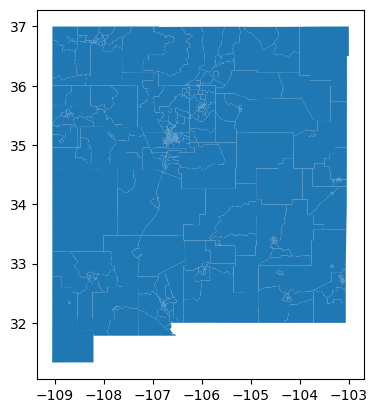

In [51]:
tracts.plot() ;


In [52]:
parties.head()

,attributes,geometry,longitude,latitude,type,address,datetime
2629,"{'OBJECTID': 2630, 'BlockAddress': '10900 BLOC...","{'x': -106.51996024236665, 'y': 35.11492481016...",-106.519960,35.114925,LOUD PARTY,10900 BLOCK LOS ARBOLES AV NE,1715462225000
4391,"{'OBJECTID': 4392, 'BlockAddress': '100 BLOCK ...","{'x': -106.55813969566555, 'y': 35.07336010349...",-106.558140,35.073360,LOUD PARTY,100 BLOCK RHODE ISLAND ST SE,1714788142000
5668,"{'OBJECTID': 5669, 'BlockAddress': 'BURTON AV ...","{'x': -106.59135300156242, 'y': 35.0717401628418}",-106.591353,35.071740,LOUD PARTY,BURTON AV SE/MONROE ST SE,1713572952000
10831,"{'OBJECTID': 10832, 'BlockAddress': '8200 BLOC...","{'x': -106.55607661490257, 'y': 35.08366312506...",-106.556077,35.083663,LOUD PARTY,8200 BLOCK MARQUETTE AV NE,1714782954000
12019,"{'OBJECTID': 12020, 'BlockAddress': '94TH ST S...","{'x': -106.73741664220728, 'y': 35.06188203166...",-106.737417,35.061882,LOUD PARTY,94TH ST SW/VISTA DEL VALLE ST SW,1714857478000


In [53]:
parties.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 2629 to 26725
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   attributes  20 non-null     object 
 1   geometry    20 non-null     object 
 2   longitude   20 non-null     float64
 3   latitude    20 non-null     float64
 4   type        20 non-null     object 
 5   address     20 non-null     object 
 6   datetime    20 non-null     int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 1.2+ KB


In [54]:
# Create geometry for parties data
parties_geo = geopandas.GeoDataFrame(parties,
                                     geometry=geopandas.points_from_xy(
                                         parties.longitude,
                                         parties.latitude
                                         )
                                     )
parties_geo.head()


,attributes,geometry,longitude,latitude,type,address,datetime
2629,"{'OBJECTID': 2630, 'BlockAddress': '10900 BLOC...",POINT (-106.51996 35.11492),-106.519960,35.114925,LOUD PARTY,10900 BLOCK LOS ARBOLES AV NE,1715462225000
4391,"{'OBJECTID': 4392, 'BlockAddress': '100 BLOCK ...",POINT (-106.55814 35.07336),-106.558140,35.073360,LOUD PARTY,100 BLOCK RHODE ISLAND ST SE,1714788142000
5668,"{'OBJECTID': 5669, 'BlockAddress': 'BURTON AV ...",POINT (-106.59135 35.07174),-106.591353,35.071740,LOUD PARTY,BURTON AV SE/MONROE ST SE,1713572952000
10831,"{'OBJECTID': 10832, 'BlockAddress': '8200 BLOC...",POINT (-106.55608 35.08366),-106.556077,35.083663,LOUD PARTY,8200 BLOCK MARQUETTE AV NE,1714782954000
12019,"{'OBJECTID': 12020, 'BlockAddress': '94TH ST S...",POINT (-106.73742 35.06188),-106.737417,35.061882,LOUD PARTY,94TH ST SW/VISTA DEL VALLE ST SW,1714857478000


In [55]:
parties_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 20 entries, 2629 to 26725
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   attributes  20 non-null     object  
 1   geometry    20 non-null     geometry
 2   longitude   20 non-null     float64 
 3   latitude    20 non-null     float64 
 4   type        20 non-null     object  
 5   address     20 non-null     object  
 6   datetime    20 non-null     int64   
dtypes: float64(2), geometry(1), int64(1), object(3)
memory usage: 1.2+ KB


See if a point is inside a tract polygon

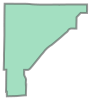

In [56]:
tracts.iloc[0]['geometry']


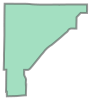

In [57]:
tracts['geometry'].iloc[0]


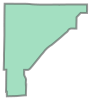

In [58]:
tracts['geometry'][0]


In [59]:
tracts0 = tracts.geometry.iloc[0]
parties0 = parties_geo.geometry.iloc[0]


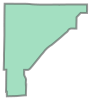

In [60]:
tracts0


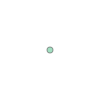

In [61]:
parties0


In [62]:
tracts0.contains(parties0)


False

In [63]:
[ x for x in dir(tracts0) if '_' not in x ]


['area',
 'boundary',
 'bounds',
 'buffer',
 'centroid',
 'contains',
 'coords',
 'covers',
 'crosses',
 'difference',
 'disjoint',
 'distance',
 'dwithin',
 'envelope',
 'equals',
 'exterior',
 'geometryType',
 'interiors',
 'interpolate',
 'intersection',
 'intersects',
 'length',
 'normalize',
 'overlaps',
 'project',
 'relate',
 'reverse',
 'segmentize',
 'simplify',
 'svg',
 'touches',
 'type',
 'union',
 'within',
 'wkb',
 'wkt',
 'xy']

In [64]:
type(tracts0)

shapely.geometry.polygon.Polygon

In [65]:
type(parties0)

shapely.geometry.point.Point

Find the centroid

In [66]:
print(tracts0.centroid)


POINT (-108.19607648249088 36.741085756281294)


Pull out lat or long for a point

In [67]:
[ x for x in dir(parties0) if '_' not in x ]


['area',
 'boundary',
 'bounds',
 'buffer',
 'centroid',
 'contains',
 'coords',
 'covers',
 'crosses',
 'difference',
 'disjoint',
 'distance',
 'dwithin',
 'envelope',
 'equals',
 'geometryType',
 'interpolate',
 'intersection',
 'intersects',
 'length',
 'normalize',
 'overlaps',
 'project',
 'relate',
 'reverse',
 'segmentize',
 'simplify',
 'svg',
 'touches',
 'type',
 'union',
 'within',
 'wkb',
 'wkt',
 'x',
 'xy',
 'y',
 'z']

In [68]:
parties0.x


-106.51996024236665

In [69]:
parties0.y


35.114924810162336

Distance between points

In [70]:
parties1 = parties_geo.geometry.iloc[1]


In [71]:
import geopy.distance


In [72]:
dist = geopy.distance.geodesic((parties0.y, parties0.x), (parties1.y, parties1.x))
dist.miles


3.5901943034366655

In [ ]:
# dist = geopy.distance.geodesic(parties0.xy, parties1.xy )
# dist.miles

Count the number of loud party incidents in each tract

In [73]:
parties

,attributes,geometry,longitude,latitude,type,address,datetime
2629,"{'OBJECTID': 2630, 'BlockAddress': '10900 BLOC...","{'x': -106.51996024236665, 'y': 35.11492481016...",-106.519960,35.114925,LOUD PARTY,10900 BLOCK LOS ARBOLES AV NE,1715462225000
4391,"{'OBJECTID': 4392, 'BlockAddress': '100 BLOCK ...","{'x': -106.55813969566555, 'y': 35.07336010349...",-106.558140,35.073360,LOUD PARTY,100 BLOCK RHODE ISLAND ST SE,1714788142000
5668,"{'OBJECTID': 5669, 'BlockAddress': 'BURTON AV ...","{'x': -106.59135300156242, 'y': 35.0717401628418}",-106.591353,35.071740,LOUD PARTY,BURTON AV SE/MONROE ST SE,1713572952000
10831,"{'OBJECTID': 10832, 'BlockAddress': '8200 BLOC...","{'x': -106.55607661490257, 'y': 35.08366312506...",-106.556077,35.083663,LOUD PARTY,8200 BLOCK MARQUETTE AV NE,1714782954000
12019,"{'OBJECTID': 12020, 'BlockAddress': '94TH ST S...","{'x': -106.73741664220728, 'y': 35.06188203166...",-106.737417,35.061882,LOUD PARTY,94TH ST SW/VISTA DEL VALLE ST SW,1714857478000
12980,"{'OBJECTID': 12981, 'BlockAddress': '1100 BLOC...","{'x': -106.60720026323625, 'y': 35.06381151882...",-106.607200,35.063812,LOUD PARTY,1100 BLOCK AMHERST DR SE,1715044492000
14358,"{'OBJECTID': 14359, 'BlockAddress': '100 BLOCK...","{'x': -106.61953947077495, 'y': 35.07953793519...",-106.619539,35.079538,LOUD PARTY,100 BLOCK CORNELL DR SE,1713671191000
16589,"{'OBJECTID': 16590, 'BlockAddress': '12700 BLO...","{'x': -106.5069956600665, 'y': 35.06656215106766}",-106.506996,35.066562,LOUD PARTY,12700 BLOCK CENTRAL AV SE,1714693973000
16795,"{'OBJECTID': 16796, 'BlockAddress': '2700 BLOC...","{'x': -106.58082074084467, 'y': 35.11207771238...",-106.580821,35.112078,LOUD PARTY,2700 BLOCK VALENCIA DR NE,1715378856000
17989,"{'OBJECTID': 17990, 'BlockAddress': '6800 BLOC...","{'x': -106.49345512471855, 'y': 35.15764920352...",-106.493455,35.157649,LOUD PARTY,6800 BLOCK PINO ARROYO CT NE,1715540260000


In [74]:
tracts['incidents'] = 0

for idx, incident in parties_geo.iterrows():
  for idx, tract in tracts.iterrows():
    if tract['geometry'].contains(incident['geometry']):
      tracts['incidents'][idx] +=1
      break


<ipython-input-74-f712eec30ee6>:6: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<ipython-input-74-f712eec30ee6>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

Keep tracks that have had at least one incident

In [75]:
tracts_abq = tracts[tracts['incidents'] != 0].copy()
tracts_abq.head()


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,incidents
25,35,001,004739,35001004739,47.39,Census Tract 47.39,G5020,S,1996108.0,1508.0,+35.0655742,-106.7356903,"POLYGON ((-106.74271 35.07254, -106.7426 35.07...",1
30,35,001,004749,35001004749,47.49,Census Tract 47.49,G5020,S,1236603.0,0.0,+35.1197801,-106.7057664,"POLYGON ((-106.71538 35.11252, -106.71464 35.1...",1
123,35,001,004737,35001004737,47.37,Census Tract 47.37,G5020,S,2683712.0,0.0,+35.0339071,-106.7464513,"POLYGON ((-106.75662 35.04155, -106.7564 35.04...",1
140,35,001,004738,35001004738,47.38,Census Tract 47.38,G5020,S,3538024.0,89947.0,+35.0319101,-106.7282173,"POLYGON ((-106.74019 35.02986, -106.74017 35.0...",1
308,35,001,003721,35001003721,37.21,Census Tract 37.21,G5020,S,40568504.0,197985.0,+35.1626152,-106.4386667,"POLYGON ((-106.49968 35.15887, -106.49929 35.1...",2


In [76]:
tracts_abq.set_index('TRACTCE', inplace = True)


In [77]:
tracts_abq


,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,incidents
TRACTCE,,,,,,,,,,,,,
004739,35,001,35001004739,47.39,Census Tract 47.39,G5020,S,1996108.0,1508.0,+35.0655742,-106.7356903,"POLYGON ((-106.74271 35.07254, -106.7426 35.07...",1
004749,35,001,35001004749,47.49,Census Tract 47.49,G5020,S,1236603.0,0.0,+35.1197801,-106.7057664,"POLYGON ((-106.71538 35.11252, -106.71464 35.1...",1
004737,35,001,35001004737,47.37,Census Tract 47.37,G5020,S,2683712.0,0.0,+35.0339071,-106.7464513,"POLYGON ((-106.75662 35.04155, -106.7564 35.04...",1
004738,35,001,35001004738,47.38,Census Tract 47.38,G5020,S,3538024.0,89947.0,+35.0319101,-106.7282173,"POLYGON ((-106.74019 35.02986, -106.74017 35.0...",1
003721,35,001,35001003721,37.21,Census Tract 37.21,G5020,S,40568504.0,197985.0,+35.1626152,-106.4386667,"POLYGON ((-106.49968 35.15887, -106.49929 35.1...",2
000114,35,001,35001000114,1.14,Census Tract 1.14,G5020,S,1295742.0,0.0,+35.1125918,-106.5243728,"POLYGON ((-106.53328 35.11472, -106.53324 35.1...",1
000109,35,001,35001000109,1.09,Census Tract 1.09,G5020,S,1278739.0,0.0,+35.1270872,-106.5245256,"POLYGON ((-106.53338 35.12822, -106.53332 35.1...",1
003100,35,001,35001003100,31,Census Tract 31,G5020,S,4383146.0,95601.0,+35.1350422,-106.6726386,"POLYGON ((-106.68988 35.13094, -106.68788 35.1...",1
000207,35,001,35001000207,2.07,Census Tract 2.07,G5020,S,2503982.0,0.0,+35.1093723,-106.5775575,"POLYGON ((-106.58784 35.10549, -106.58783 35.1...",1


In [80]:
tracts_abq["MTFCC"].value_counts()


,count
MTFCC,
G5020,18


In [78]:
fig = px.choropleth_mapbox(tracts_abq,
                            geojson = tracts_abq.geometry,
                            locations=tracts_abq.index,
                            color='incidents',
                            color_continuous_scale="Viridis",
                            mapbox_style = 'carto-positron',
                            zoom = 10,
                            center = {"lat": 35.0844, "lon": -106.6504},
                            opacity = .7
                           )
fig.update_geos(fitbounds="locations", visible=False)
fig.show()
